In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/daily-climate-time-series-data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
from sklearn.metrics import mean_squared_error
import seaborn as sn
import os
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
os.listdir('/kaggle/input/daily-climate-time-series-data')
API_KEY="<YOUR API KEY>" #Get it from https://www.weatherapi.com/

['DailyDelhiClimateTrain.csv', 'DailyDelhiClimateTest.csv']

In [ ]:
def generate_weekly(df):
  data=np.array([])
  for i in range(0,len(df),7):
    data=np.append(data,np.mean(df.iloc[i:i+7,1:2]))
    i=i+7
  return data

In [ ]:
train_df=pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
test_df=pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

In [ ]:
train_df=generate_weekly(train_df)
test_df=generate_weekly(test_df)

<Axes: >

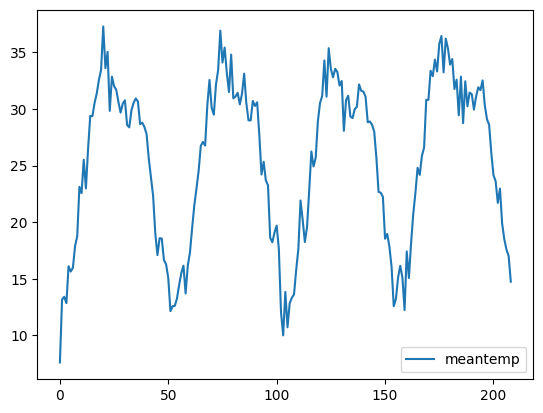

In [ ]:
sn.lineplot(train_df)

<Axes: >

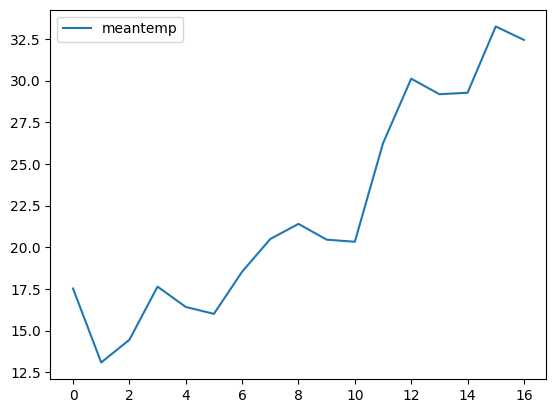

In [ ]:
sn.lineplot(test_df)

In [ ]:
train_df=pd.DataFrame(train_df,columns=['meantemp'])
test_df=pd.DataFrame(test_df,columns=['meantemp'])

In [ ]:
from statsmodels.tsa.stattools import adfuller

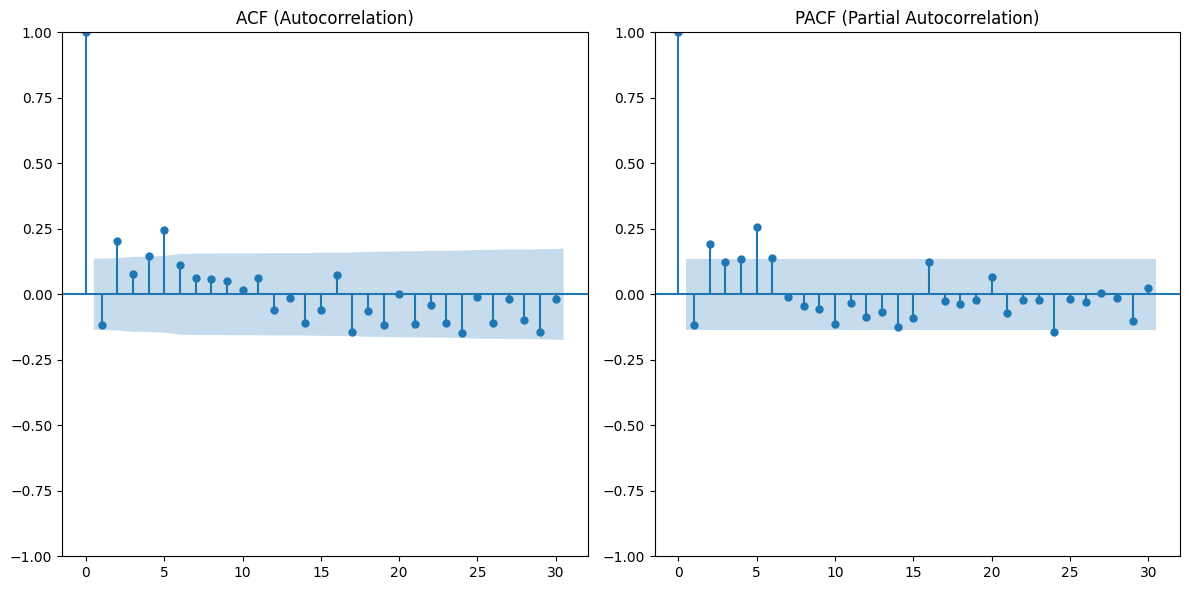

In [ ]:
diff_series =train_df['meantemp'].diff(1).dropna()
mp.figure(figsize=(12, 6))
mp.subplot(1, 2, 1)
plot_acf(diff_series,ax=mp.gca(),lags=30)
mp.title("ACF (Autocorrelation)")
mp.subplot(1, 2, 2)
plot_pacf(diff_series,ax=mp.gca(),lags=30,method='ywm')
mp.title("PACF (Partial Autocorrelation)")
mp.tight_layout()
mp.show()

p=5 d=1 q=5

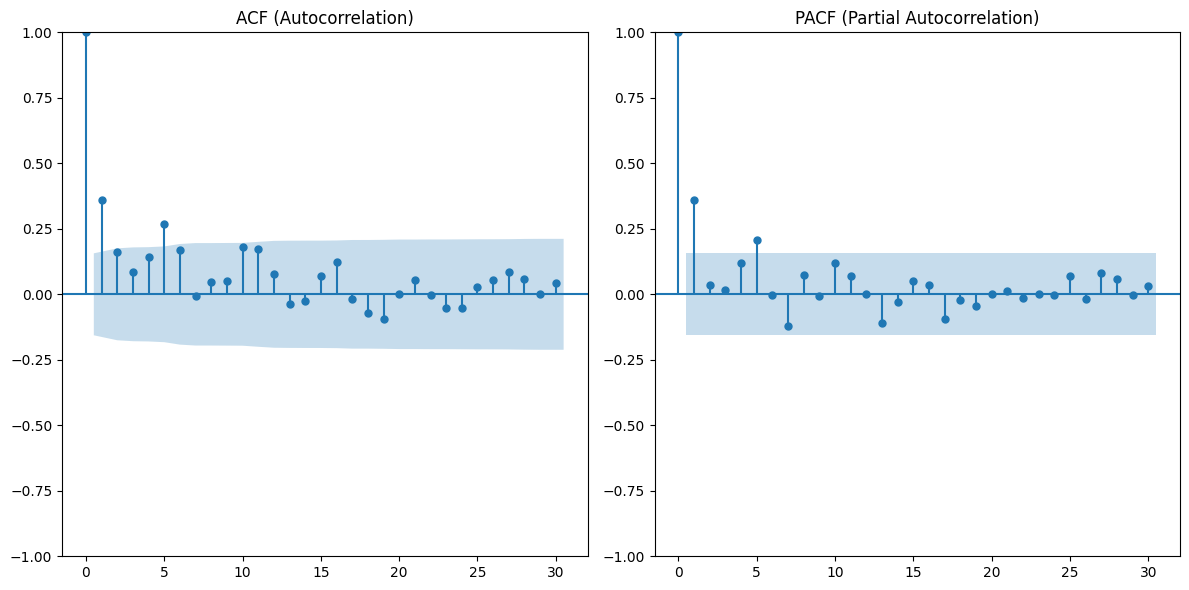

In [ ]:
diff_series =train_df['meantemp'].diff(52).dropna()
mp.figure(figsize=(12, 6))
mp.subplot(1, 2, 1)
plot_acf(diff_series,ax=mp.gca(),lags=30)
mp.title("ACF (Autocorrelation)")
mp.subplot(1, 2, 2)
plot_pacf(diff_series,ax=mp.gca(),lags=30,method='ywm')
mp.title("PACF (Partial Autocorrelation)")
mp.tight_layout()
mp.show()

P=1 D=1 Q=1

In [ ]:
result = adfuller(diff_series.dropna())
# Unpack results
adf_stat = result[0]
p_value = result[1]
critical_values = result[4]
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)
print("Critical Values:",critical_values)

ADF Statistic: -8.604325256702413
p-value: 6.736253992860209e-14
Critical Values: {'1%': np.float64(-3.4729792729247793), '5%': np.float64(-2.8802520918255534), '10%': np.float64(-2.5767469641683105)}


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train_df['meantemp'],order=(5,1,5),seasonal_order=(1,1,1,52))
final_model=model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Found input variables with inconsistent numbers of samples: [17, 10]

RMSE: 3.0909


<Axes: xlabel='None', ylabel='meantemp'>

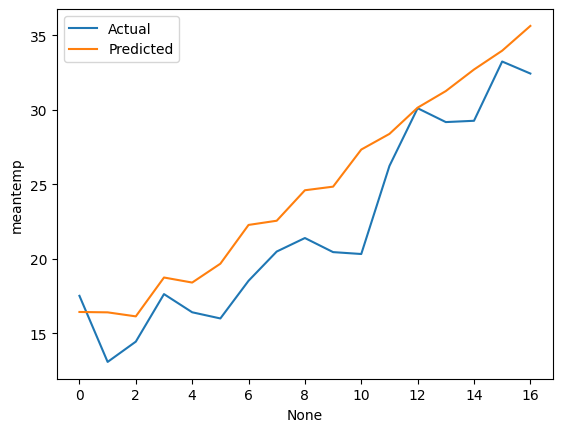

In [ ]:
result=final_model.forecast(steps=17)
rmse = np.sqrt(mean_squared_error(test_df['meantemp'],result))
print(f"RMSE: {rmse:.4f}")
sn.lineplot(x=test_df.index,y=test_df['meantemp'],label='Actual')
sn.lineplot(x=test_df.index,y=result,label='Predicted')

The model is ready to make inferences now the temperature might have shifted in its trends, seasonality but for the time being we assumneit has followed a roughly-same time series

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
def get_past_week_weather(api_key=API_KEY, city="Delhi"):
    base_url = "http://api.weatherapi.com/v1/history.json"
    past_weather = []
    for i in range(54):
        date = (datetime.today() - timedelta(days=i)).strftime("%Y-%m-%d")
        url = f"{base_url}?key={api_key}&q={city}&dt={date}"
        res = requests.get(url)
        data = res.json()
        try:
            avg_temp = data['forecast']['forecastday'][0]['day']['avgtemp_c']
            past_weather.append({'Date': date, 'Temperature': avg_temp})
        except:
            print(f"Data not available for {date}")

    df = pd.DataFrame(past_weather).sort_values("Date")
    df["Date"] = pd.to_datetime(df["Date"])
    return df


In [ ]:
curr_df=get_past_week_weather()
curr_df=generate_weekly(curr_df)
curr_df=pd.DataFrame(curr_df,columns=['meantemp'])


In [ ]:
curr_df

,meantemp
0,18.757143
1,16.628571
2,21.528571
3,21.585714
4,22.942857
5,22.671429
6,22.185714
7,20.660000


<Axes: xlabel='None', ylabel='meantemp'>

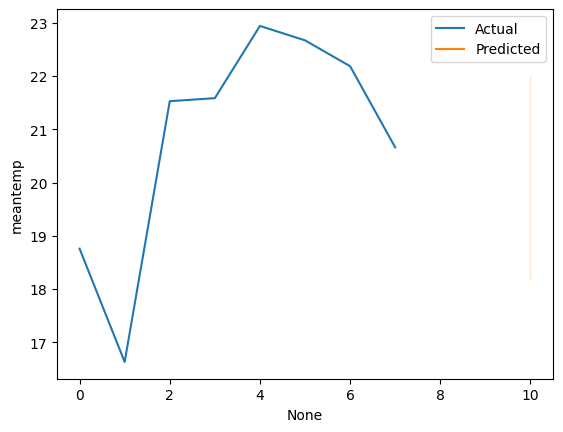

In [ ]:
preds=final_model.forecast(steps=10)
sn.lineplot(x=curr_df.index,y=curr_df['meantemp'],label='Actual')
sn.lineplot(x=len(preds),y=preds,label='Predicted')

In [ ]:
preds

,predicted_mean
209,16.436103
210,16.411254
211,16.141433
212,18.749342
213,18.410744
214,19.676151
215,22.277854
216,22.559721
217,24.604536
218,24.846851


In [ ]:
import pickle
with open("arima_model.pkl", "wb") as f:
    pickle.dump(final_model,f)

In [ ]:
!pip install joblib


In [ ]:
import joblib
joblib.dump(final_model,"model.joblib")

['model.joblib']